<a href="https://colab.research.google.com/github/CrushedKatana/Machine_Learning/blob/main/JS15_TG01_2341720205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 1

### Langkah 1: Import Library dan Mount Google Drive

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Langkah 2: Load Dataset

In [ ]:
import os

# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    if not p.exists():
        print(f"Warning: Directory does not exist: {img_dir}")
        return img_list

    found_images = False
    for folder in p.glob('*'):
        if folder.is_dir(): # Ensure it's a directory
            label = folder.name
            for file in folder.glob('*.jpg'):
                img = cv2.imread(str(file))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_list.append((img, label))
                    found_images = True
                else:
                    print(f"Warning: Could not read image file: {file}")

    if not found_images and p.exists():
        print(f"Warning: No JPG images found in {img_dir} or its subdirectories. Please check the path and file extensions.")

    return img_list

train_dir = "/content/drive/MyDrive/Machine_Learning/images/images/training/"
test_dir  = "/content/drive/MyDrive/Machine_Learning/images/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


### Langkah 3: Preprocessing (Resize & Label Encoding)

In [ ]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

### Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

In [ ]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

### Langkah 5: Normalisasi Fitur

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

### Langkah 6: Split Data Training & Validation

In [ ]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

### Langkah 7: Konversi Label ke Numpy Array

In [ ]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Langkah 8: Membangun Arsitektur Model Neural Network

In [ ]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

### Langkah 9: Training Model

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.6770 - loss: 0.8731 - val_accuracy: 0.9583 - val_loss: 0.3890
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9743 - loss: 0.2078 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9792 - val_loss: 0.0490
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 4.1883e-04 - val_accuracy: 1.0000 - val_loss: 7.1749e-04
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 5.6177e-05 - val_accuracy: 1.0000 - val_loss: 5.6835e-04
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.0529e-05 - val_accuracy: 1.0000 - val_loss: 3.3629e-04
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.9654e-06 - val_accuracy: 1.0000 - val_loss: 2.3191e-04
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.4283e-06

### Langkah 10: Evaluasi Model

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9293 - loss: 0.4746
Akurasi Test: 0.9375


### Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

In [ ]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        80
           1       0.96      0.91      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[77  3]
 [ 7 73]]


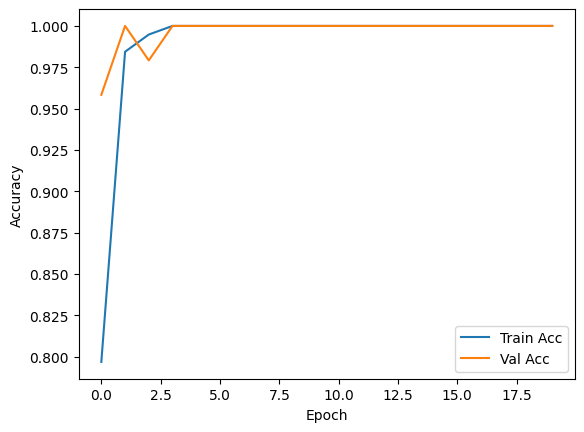

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Langkah 12: Menyimpan Model dan Scaler

In [ ]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl


## Lab 2

### Langkah 1: Persiapan Environmen

In [29]:
import os

source_path = '/content/daynight-project'
destination_path = '/content/drive/MyDrive/Machine_Learning/'

# Ensure the destination directory exists
if not os.path.exists(destination_path):
    os.makedirs(destination_path)
    print(f"Created destination directory: {destination_path}")

# Move the directory
!mv {source_path} {destination_path}

print(f"Directory '{source_path}' moved to '{destination_path}'")

mv: cannot stat '/content/daynight-project': No such file or directory
Directory '/content/daynight-project' moved to '/content/drive/MyDrive/Machine_Learning/'


In [ ]:
import os

# Change the current working directory
new_working_directory = os.path.join(destination_path, 'daynight-project')
os.chdir(new_working_directory)

print(f"Current working directory changed to: {os.getcwd()}")

Current working directory changed to: /content/drive/MyDrive/Machine_Learning/daynight-project


### Langkah 2: Konfigurasi Server (app.py)

In [ ]:
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

# Load Model & Scaler
MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("✅ System Loaded Successfully")
except Exception as e:
    print(f"❌ Error loading system: {e}")

def preprocess_image(image_bytes):
    # Decode gambar
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Preprocessing (Harus sama persis dengan Training)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Prediksi</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]

        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Hasil: {label}</h2><center><a href='/'>Kembali</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    # Port 7860 wajib untuk Hugging Face Spaces
    app.run(host='0.0.0.0', port=7860)

✅ System Loaded Successfully
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:7860
 * Running on http://172.28.0.12:7860
INFO:werkzeug:Press CTRL+C to quit
